# Predict Titanic Survival

The RMS Titanic set sail on its maiden voyage in 1912, crossing the Atlantic from Southampton, England to New York City. The ship never completed the voyage, sinking to the bottom of the Atlantic Ocean after hitting an iceberg, bringing down 1,502 of 2,224 passengers onboard.

The goal of this project is to create a Logistic Regression model that predicts which passengers survived the sinking of the Titanic, based on features like age, class and other relevant parameters.

The data we will be using for training our model is provided by Kaggle.

Columns description:

- `PassengerId:` passenger identification number;
- `Survived:` binary code, that denotes whether a passenger survived (1 - "Yes") or not (0 - "No").
- `Pclass:` passenger class: 1 - 1st, 2 - 2nd, 3 - 3rd;
- `Name:` passenger name;
- `Sex:` passenger sex;
- `Age:` passenger age;
- `SibSp:` number of siblings/ spauses aboard;
- `Parch:` number of parants/ children aboard;
- `Ticket:` ticket number;
- `Fare:` passenger fare (£);
- `Cabin:` cabin number;
- `Embarked:` port of embarcation (C- Cherbourg, S- Southampton,Q- Queenstown )


## Exploring Data

The file passengers.csv contains the data of 892 passengers onboard the Titanic when it sank that fateful day. Let’s begin by loading the data into a pandas DataFrame named `passengers`, then print it and inspect the columns. 

In [283]:
# Basic imports related to analysis
import pandas as pd
import numpy as np

# Import for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for ml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Imports related to evaluation
from sklearn.metrics import classification_report

In [284]:
# Load the passenger data
passengers = pd.read_csv('passengers.csv')
passengers.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [204]:
passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Let's print unique values of columns that have a low number of variations in their values to see if everything is ok there. 

In [205]:
columns = ['Pclass', 'SibSp', 'Parch', 'Sex', 'Survived', 'Embarked']
for i in range(len(columns)):
    print(columns[i], passengers[columns[i]].unique())

Pclass [3 1 2]
SibSp [1 0 3 4 2 5 8]
Parch [0 1 2 5 3 4 6]
Sex ['male' 'female']
Survived [0 1]
Embarked ['S' 'C' 'Q' nan]


In [206]:
passengers.Ticket.unique()[:20]

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649'], dtype=object)

In [207]:
len(passengers.Ticket.unique())

681

Result: 
- A lot of values are missing in the `Age` column, and we'll need this column for feature engineering, so we are going to deal with during feature engineering stage. 
- Much worse situation with the `Cabin`, most of the data is absent, so we won't be able to use it as a feature.  
- The `Embarked` has some missing values, and we'll check its correlation with survival during feature engineering.
- Situation with `Ticket`s is also complicated because there are `681`  unique tickets out of `981` data points and there is no obvious structure to them, so we'll set them aside for now.

Let's check some statistics for this dataset.

In [208]:
passengers.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [209]:
passengers.sort_values('Fare', ascending=False).head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S


In [210]:
passengers.sort_values('Fare', ascending=True).head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S


In [211]:
len(passengers[passengers.Fare == 0])

15

Result: There is an issue with the `Fare`, it appears that 3 passengers paid a lot more than others - about `512£`, and 15 paid `0£` for their tickets. That may affect visualizations and will create a huge bias that "poor people are likely to die" in our model, but right now our goal right now is to create model based on real data with all its inequalities, so let's proceed as it is for now later we will replace `0`s with relevant values not destirbing the current values distribution.

## Feature Engineering

Logistic regression is a supervised machine learning algorithm that predicts the probability, ranging from 0 to 1, of a data point belonging to a specific category, or class. These probabilities can then be used to assign, or classify, observations to the more probable group. As the name of this project suggests, we are going to estimate the chances of survival on Titanic, so our class of determination will be `Survived`. Consequently, our model will predict survival to be `0` meaning would not survive, and `1` - would survive, based on significant parameters or features. To find these features we'll analyse existing parameters to get a sense how well they suit our purposes and what additional tweaks should we make to make them better for our model.  

Let's check correlations between `Survived` and other parameters on a heatmap to find potential features for our model. But before that we need to attend to our `Sex` and `Embarked` columns: to perform any calculations we need numerical values there. So let’s map the text values in the `Sex` and `Embarked` columns to numerical values. 

All values `female` will be replaced with `1` and all values `male` will be replaced with `0`.

In [212]:
# Update sex column to numerical
passengers['Sex_num'] = passengers.Sex.map({'female': 1, 'male': 0})

All values `S` will be replaced with `0`, all values `C` will be replaced with `1` and all values with `Q` will be replaced with `2`.

In [213]:
passengers['Embarked_num'] = passengers.Embarked.map({'S': 1, 'C': 2, 'Q': 3}).convert_dtypes()

<AxesSubplot:title={'center':"Titanic's Passengers Parameters Correlation"}>

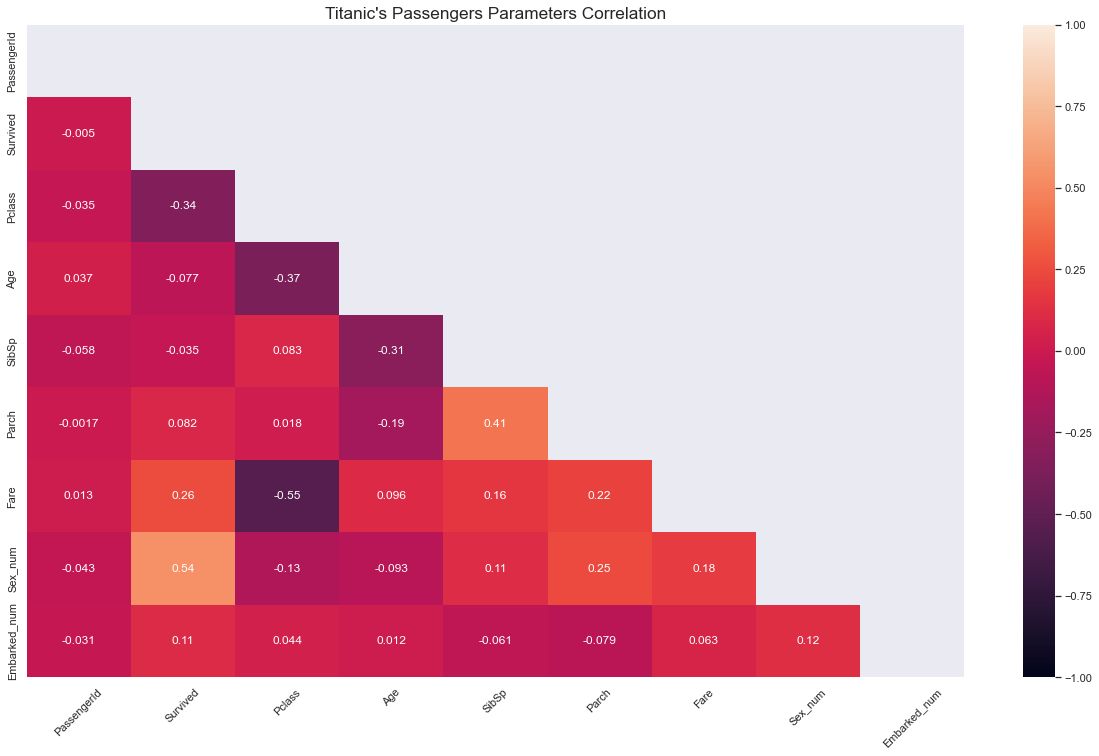

In [214]:
def visualise_heatmap(dataset_corr, corr_objects):
    # Prepare figure
    plt.figure(figsize = (21,12))

    # Draw heatmap as triangle
    mask = np.triu(np.ones_like(dataset_corr, dtype=bool))
    # Add descriptions
    plt.title(corr_objects, fontsize= 'x-large')
    plt.xticks(rotation=45)

    # Plot heatmap
    heatmap = sns.heatmap(dataset_corr, annot=True, vmax=1, vmin=-1, cmap='rocket', mask=mask)
    return heatmap

visualise_heatmap(passengers.corr(), 'Titanic\'s Passengers Parameters Correlation') 

Result: 
- In reality `Age` has no significant correlation with survival, `Sex` on the contrary, has medium positive correlation (`0.54`) with survival. So first our feature will definitely be `Sex`. 
- `Fare` and `Pclass` look promissing as features with positive correlation of `0.26` and negative `-0.34` respectively. So we are going to take them as well. 
- Seems like `Embarked_num` has small positive correlation - `0.11`, so it can be used as a feature too.
- `Age`, `Parch`(number of parents/children on board) and `SibSp` (number of siblings/ spauses aboard) can be used as additional features. 

Now let's see what flaws our features can have and what can we do about it. We'll start with a simple `Fare` histogram.

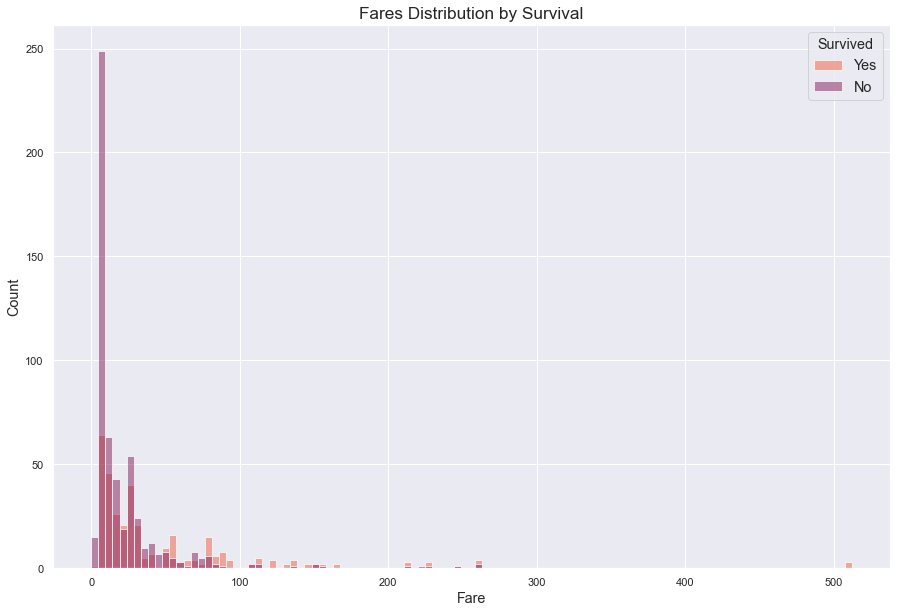

In [215]:
# Set darkgrid for all plots of the project
sns.set(style='darkgrid')

def visualise_hist(dataset, column_names, palette, title, xlabel, ylabel):
    # Prepare figure
    plt.figure(figsize = (15,10))
    # Draw hisplot
    ax = sns.histplot(
        passengers, 
        x=column_names[0], 
        hue=column_names[1], 
        stat="count", 
        legend=False, 
        palette=palette
        )

    # Add descriptions
    ax.set_title(title, fontsize = 'x-large')
    ax.set_xlabel(xlabel, fontsize = 'large')
    ax.set_ylabel(ylabel, fontsize = 'large')

    plt.legend(
        title='Survived', 
        title_fontsize='large', 
        loc='upper right', 
        labels=['Yes', 'No'], 
        fontsize = 'large')
    return plt.show()

visualise_hist(
    passengers, 
    column_names=['Fare', 'Survived'], 
    palette='rocket', 
    title='Fares Distribution by Survival', 
    xlabel='Fare', 
    ylabel='Count')

Result: 
- Histogram is heavily skewed to the right, because of 3 outliers who paid `512£` and some others who also paid very high prices for their tickets. 
- There is also a high peak which tells us that the majority of those who died had low fare tickets. 

Both these factors will create huge bias toward the death of people with low income in our model, but that is the hard truth about "Titanic" history, so we'll not do anything to prevent these bias from happening.

Now we are going to display on several graphs relationships between several variables to find how the number of survivors changes based on such parameters as `Sex`, `Age` and `Fare`. First we'll explore the general numbers of survivors depending on `Sex` parameter on a histogram. 

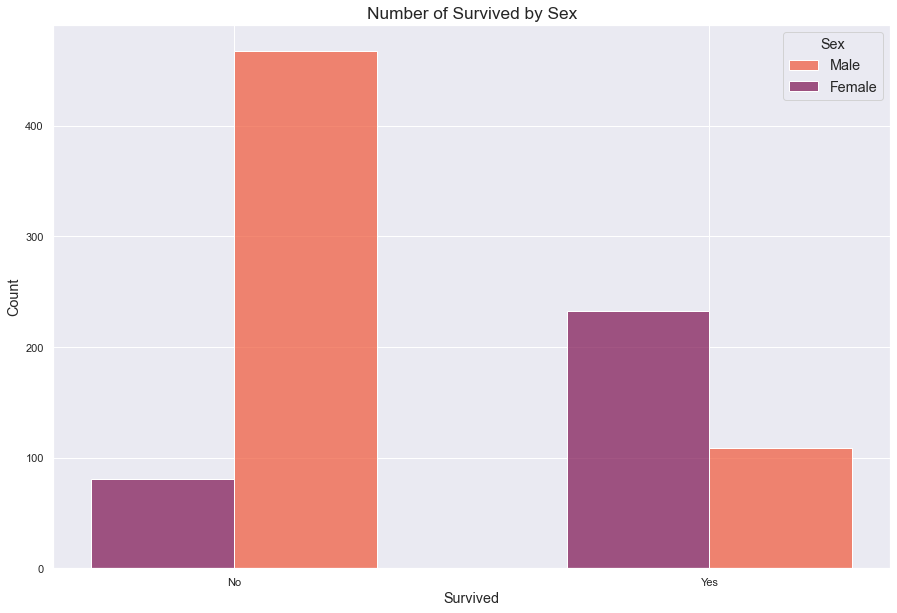

In [216]:
# Create separate column with Survived values in str to correctly draw histplot
passengers['Survived_str'] = passengers.Survived.map({0:'No', 1:'Yes'}).astype(str)

def visualise_hist(dataset, column_names, palette, title, xlabel, ylabel, hue_order, set_xticks, legend_title, legend_labels):
    # Prepare figure
    plt.figure(figsize = (15,10))
    # Draw hisplot
    ax = sns.histplot(
        data=dataset, 
        x=column_names[0], 
        hue=column_names[1],
        hue_order=hue_order, 
        shrink=0.6, 
        multiple='dodge', 
        palette= palette,
        legend=False
        )

    # Add descriptions
    ax.set_title(title, fontsize = 'x-large')
    ax.set_xlabel(xlabel, fontsize = 'large')
    ax.set_ylabel(ylabel, fontsize = 'large')
    ax.set_xticks(set_xticks)

    plt.legend(
        title=legend_title, 
        title_fontsize='large', 
        loc='upper right', 
        labels=legend_labels, 
        fontsize = 'large')

    return plt.show()

visualise_hist(
    passengers, 
    column_names=['Survived_str', 'Sex'], 
    palette='rocket', 
    title='Number of Survived by Sex', 
    xlabel='Survived', 
    ylabel='Count',
    hue_order=['female','male'], 
    set_xticks=[0, 1], 
    legend_title='Sex', 
    legend_labels=['Male', 'Female']
    )


Result: 
- Clearly, most of the people died, among them the majority were males.
- A little more than 200 women and about 100 men survived. 

Let's see what place of embarkation will be able to tell us.

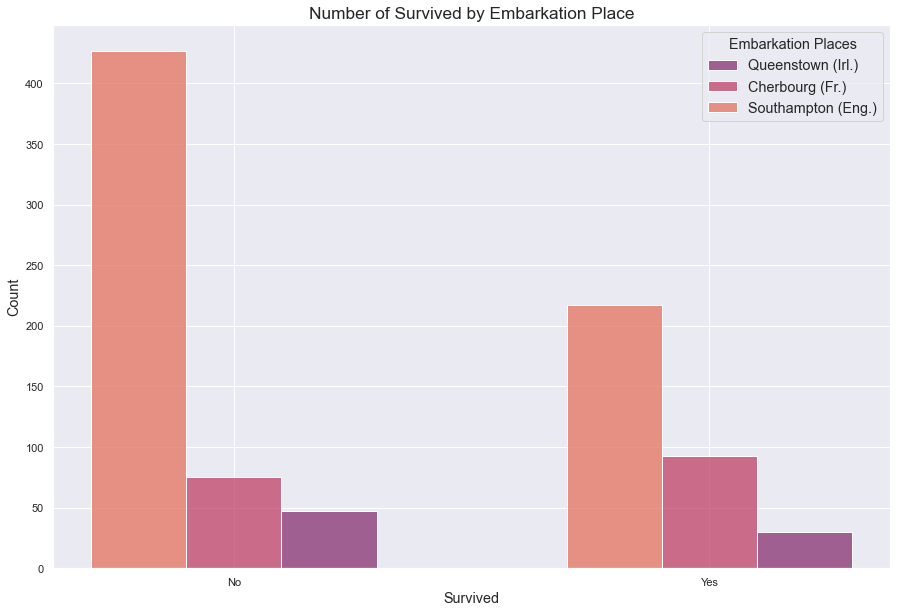

In [217]:
visualise_hist(
    passengers, 
    column_names=['Survived_str', 'Embarked'], 
    palette='flare', 
    title='Number of Survived by Embarkation Place', 
    xlabel='Survived', 
    ylabel='Count',
    hue_order=['S', 'C', 'Q'], 
    set_xticks=[0, 1], 
    legend_title='Embarkation Places', 
    legend_labels=['Queenstown (Irl.)', 'Cherbourg (Fr.)', 'Southampton (Eng.)']
    )

In [218]:
passengers.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Result: 
- Most people embarked in England, some in France and few in Ireland. 
- More of those who embarked in Ireland died, same goes for those from England, but for those from France it's vice versa.

Now let's see on a box-plot the change in survival of men and women depending on `Age` parameter.

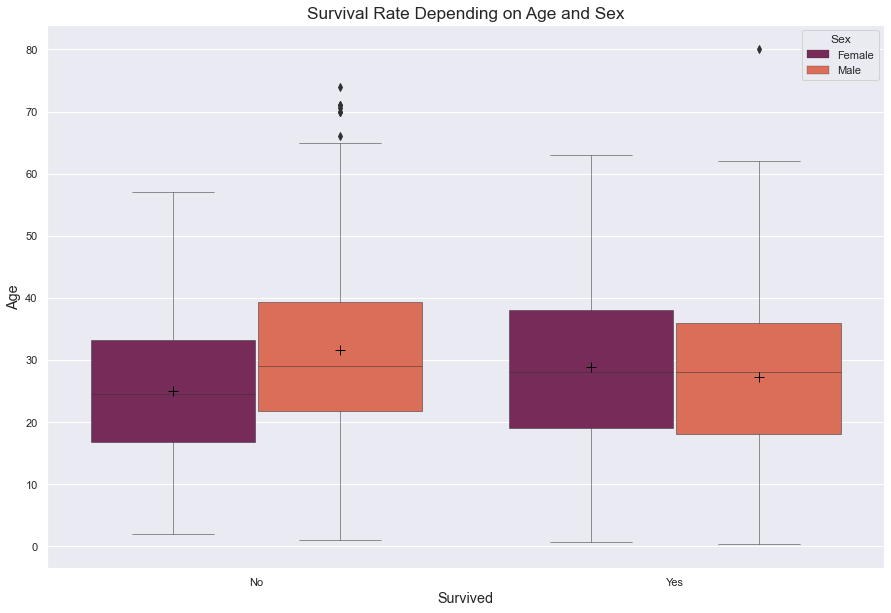

In [219]:
# Draw boxplot
def visualise_boxplot(dataset, column_names, palette, title, xlabel, ylabel):
    plt.figure(figsize = (15,10))
    ax = sns.boxplot(
        data=dataset,
        x= column_names[0], 
        y= column_names[1],
        hue=column_names[2],
        hue_order=[1,0],
        palette=palette, 
        showmeans=True,
        meanprops={"marker": "+",
            "markeredgecolor": "black",
            "markersize": "10"},
        linewidth=0.5)

    # Add descriptions
    ax.set_title(title, fontsize = 'x-large')
    ax.set_xlabel(xlabel, fontsize = 'large')
    ax.set_ylabel(ylabel, fontsize = 'large')
    ax.set_xticklabels(['No', 'Yes'])
    
    ax.legend(title='Sex')
    ax.legend_.texts[0].set_text('Female')
    ax.legend_.texts[1].set_text('Male')

    return plt.show()

visualise_boxplot(
    passengers, 
    column_names=['Survived', 'Age', 'Sex_num'], 
    palette='rocket', 
    title='Survival Rate Depending on Age and Sex', 
    xlabel='Survived', 
    ylabel='Age'
)

In [220]:
passengers.sort_values('Age', ascending=False).head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_num,Embarked_num,Survived_str
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S,0,1,Yes
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S,0,1,No
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C,0,2,No
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C,0,2,No
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,0,3,No


Result: 
- Among females survived those who are generally older - around `22-38` years. 
- Children clearly weren't major group among survivers. 
- Among males the other way around - survived those who generally younger in a range from `18` to `37` or so, with one outlier who is `80`. 

Now let's check what ratios we'll get if we'll focus on `Fare` and `Sex`.

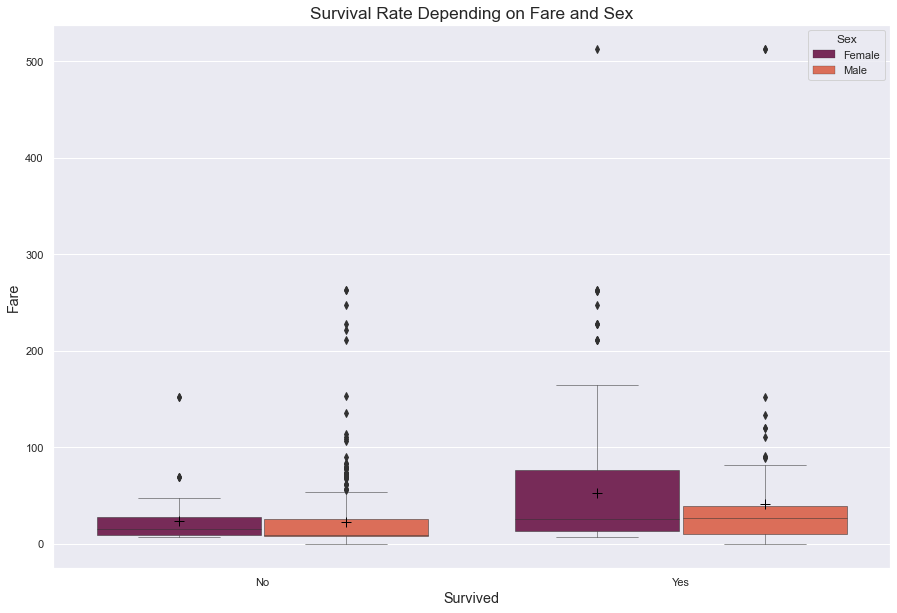

In [221]:
visualise_boxplot(
    passengers, 
    column_names=['Survived', 'Fare', 'Sex_num'], 
    palette='rocket', 
    title='Survival Rate Depending on Fare and Sex', 
    xlabel='Survived', 
    ylabel='Fare'
)

Data is squashed by outliers who had high fare tickets. Let's set a temporary limitation on `Fare` data to be `less than 150` to see data more clearly on this particular plot. 

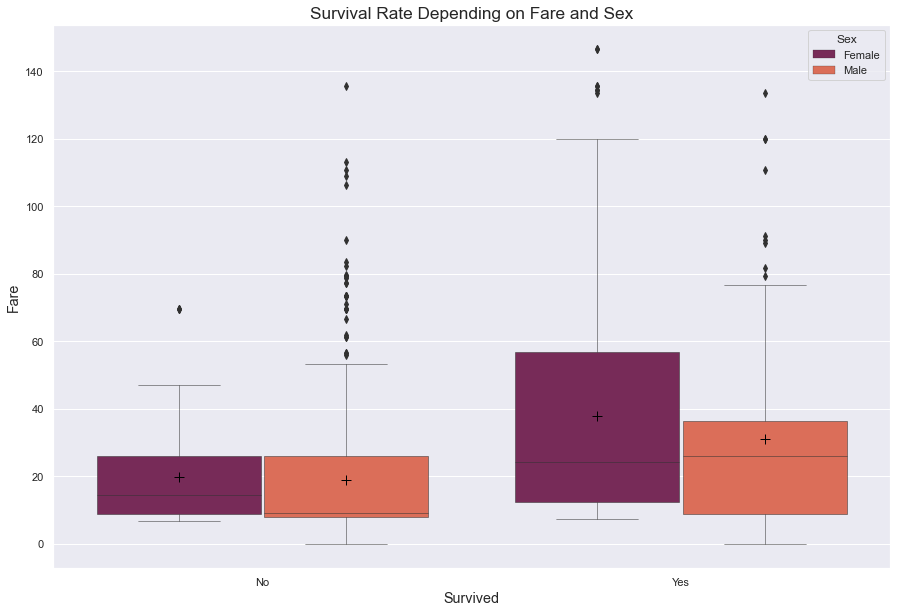

In [222]:
visualise_boxplot(
    passengers, 
    column_names=['Survived', passengers.Fare[passengers.Fare < 150], 'Sex_num'], 
    palette='rocket', 
    title='Survival Rate Depending on Fare and Sex', 
    xlabel='Survived', 
    ylabel='Fare'
)

Result: 
- There is a big gap between median (horizontal line on the box) and mean (`+` sign), which telling us that data is still seriously affected by `Fare` outliers that have high values. 
- Among survivors a lot of females in general, but more of those who managed to pay at least `10£` or more for their tickets.  
- Surprisingly enough there are not only a lot of males and females who had low-priced tickets died, but also some of the males who paid `100£` and more for theirs, what supports the saying "Women and children first", at least to some extent. 

Now we are going to tweak our features to make them suitable for model. Let's start with creating new dataframe features that consists only of features.


In [223]:
passengers_short = passengers[['Survived', 'Sex_num', 'Fare', 'Pclass', 'Embarked_num', 'Age', 'SibSp', 'Parch']].reset_index(drop=True)
passengers_short.head()

,Survived,Sex_num,Fare,Pclass,Embarked_num,Age,SibSp,Parch
0,0,0,7.2500,3,1,22.0,1,0
1,1,1,71.2833,1,2,38.0,1,0
2,1,1,7.9250,3,1,26.0,0,0
3,1,1,53.1000,1,1,35.0,1,0
4,0,0,8.0500,3,1,35.0,0,0


There were a lot of `nan`s in `Age` column, when we last check, so now it's time to deal with it to prepare this column for the model.

In [224]:
passengers_short.Age.unique()[:15]

array([22., 38., 26., 35., nan, 54.,  2., 27., 14.,  4., 58., 20., 39.,
       55., 31.])

There are some `nan`s so let's fill all the empty `Age` values in passengers with the mean age.

In [225]:
# Fill the nan values in the age column
passengers_short.Age.fillna(value=passengers_short.Age.mean().round(2), inplace=True)
passengers_short.Age.unique()[:15]

array([22. , 38. , 26. , 35. , 29.7, 54. ,  2. , 27. , 14. ,  4. , 58. ,
       20. , 39. , 55. , 31. ])

Now we are going to replace absent values in `Embarked_num`, let's see how many there are. 

In [226]:
passengers_short[passengers_short.Embarked_num.isna()]

,Survived,Sex_num,Fare,Pclass,Embarked_num,Age,SibSp,Parch
61,1,1,80.0,1,<NA>,38.0,0,0
829,1,1,80.0,1,<NA>,62.0,0,0


Considering there are only 2 passengers with absent numbers we can replace `nan`s manually. We'll replace `nan`s with `3` (Queenstown), considering this place of embarkation is underrepresented.

In [227]:
passengers_short.Embarked_num.fillna(3, inplace=True)

In [228]:
passengers_short.Fare.sort_values(ascending=True).unique()[:10]

array([0.    , 4.0125, 5.    , 6.2375, 6.4375, 6.45  , 6.4958, 6.75  ,
       6.8583, 6.95  ])

When dealing with `Fare`, first we are going to replace all `0`s with small random `float` values.

In [229]:
rng = np.random.default_rng(123)
rints = (rng.random(size=15) * 10 + 5).round(4)
rints

array([11.8235,  5.5382,  7.2036,  6.8437,  6.7591, 13.1209, 14.2334,
        7.7657, 13.1975, 13.8989, 10.1297,  7.4496, 13.2424,  7.1376,
       12.4147])

In [230]:
for i in range(len(rints)):
    passengers_short.Fare.replace(to_replace = 0.0, value = rints[i], inplace=True)

# Check if any 0s left
len(passengers_short[passengers_short.Fare == 0])

0

We also are going to apply One-Hot encoding to `Sex_num`, `Pclass`, `Embarked_num` to show that there is no inherent order among the values of categorical data. 

In [231]:
passengers_short = pd.get_dummies(data=passengers_short, columns=['Sex_num', 'Pclass', 'Embarked_num'])
passengers_short.head()

,Survived,Fare,Age,SibSp,Parch,Sex_num_0,Sex_num_1,Pclass_1,Pclass_2,Pclass_3,Embarked_num_1,Embarked_num_2,Embarked_num_3
0,0,7.2500,22.0,1,0,1,0,0,0,1,1,0,0
1,1,71.2833,38.0,1,0,0,1,1,0,0,0,1,0
2,1,7.9250,26.0,0,0,0,1,0,0,1,1,0,0
3,1,53.1000,35.0,1,0,0,1,1,0,0,1,0,0
4,0,8.0500,35.0,0,0,1,0,0,0,1,1,0,0


## Select and Split the Data

Now that we have cleaned and prepared our data, let’s select the columns we want to build our model on and store them in a variable named `features`. After that we'll select column `Survived` and store it a variable named `survival`.

In [232]:
features = passengers_short[['Fare', 'Age', 'SibSp', 'Parch', 'Sex_num_0', 'Sex_num_1',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_num_1', 'Embarked_num_2',
       'Embarked_num_3']]
features.head(5)

,Fare,Age,SibSp,Parch,Sex_num_0,Sex_num_1,Pclass_1,Pclass_2,Pclass_3,Embarked_num_1,Embarked_num_2,Embarked_num_3
0,7.2500,22.0,1,0,1,0,0,0,1,1,0,0
1,71.2833,38.0,1,0,0,1,1,0,0,0,1,0
2,7.9250,26.0,0,0,0,1,0,0,1,1,0,0
3,53.1000,35.0,1,0,0,1,1,0,0,1,0,0
4,8.0500,35.0,0,0,1,0,0,0,1,1,0,0


In [233]:
survival = passengers_short[['Survived']]

Now let's split the data into training and test sets. We’ll use the training set to train the model and the test set to evaluate the model.

In [234]:
# Perform train, test, split
train_data, test_data, train_cats, test_cats = train_test_split(features, survival)

## Normalize the Data

We are going to apply z-scaling - scale the feature data, so it has mean = 0 and standard deviation = 1, to remove impact of different scales within it on the model performance, sklearn‘s Logistic Regression implementation uses implies normalization anyway.  

In [235]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

## Create & Evaluate Logistic Regression Model 

Fitting the model will perform gradient descent to find the feature coefficients that minimize the log-loss for the training data.

In [236]:
model = LogisticRegression()
model.fit(train_scaled, train_cats.Survived)

LogisticRegression()

The score function should return the percentage of correct classifications on testing data, or the accuracy.

In [237]:
print('Accuracy:', model.score(test_scaled, test_cats.Survived).round(1)*100, '%')

Accuracy: 80.0 %


In [285]:
# Calculate evaluation metrics
print(classification_report(test_cats.Survived, model.predict(test_scaled)))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       142
           1       0.73      0.79      0.76        81

    accuracy                           0.82       223
   macro avg       0.80      0.81      0.80       223
weighted avg       0.82      0.82      0.82       223



Accuracy level is sufficient, so now we can proceed with our research. So let's answer the question which feature is most important in predicting a passenger's survival on the sinking of the Titanic? To answer that we'll use model's coefficients, which are a good indicator of model's inner priorities. Let's find minimum and maximum coefficients i.e. most impactful in the list from model's perspective. 

In [238]:
model.coef_[0].max(), model.coef_[0].min()

(0.5978348798795259, -0.5978348798795259)

In [239]:
list(zip(features.columns[:],model.coef_[0]))

[('Fare', 0.055196328395891905),
 ('Age', -0.5601920664596024),
 ('SibSp', -0.38412020234773425),
 ('Parch', 0.04467306575588518),
 ('Sex_num_0', -0.5978348798795259),
 ('Sex_num_1', 0.5978348798795259),
 ('Pclass_1', 0.5622082888081089),
 ('Pclass_2', 0.06725755615570136),
 ('Pclass_3', -0.5294654423961637),
 ('Embarked_num_1', -0.10962572644530263),
 ('Embarked_num_2', 0.07228299766942983),
 ('Embarked_num_3', 0.07207655254319037)]

Looks like the feature with the maximum positive or negative impact on Titanic was person's sex, it means that being female would increase survival chances more than everything else and being male on the opposite decrease them drastically. Let's put coefficients on a graph to have a better understanding. 

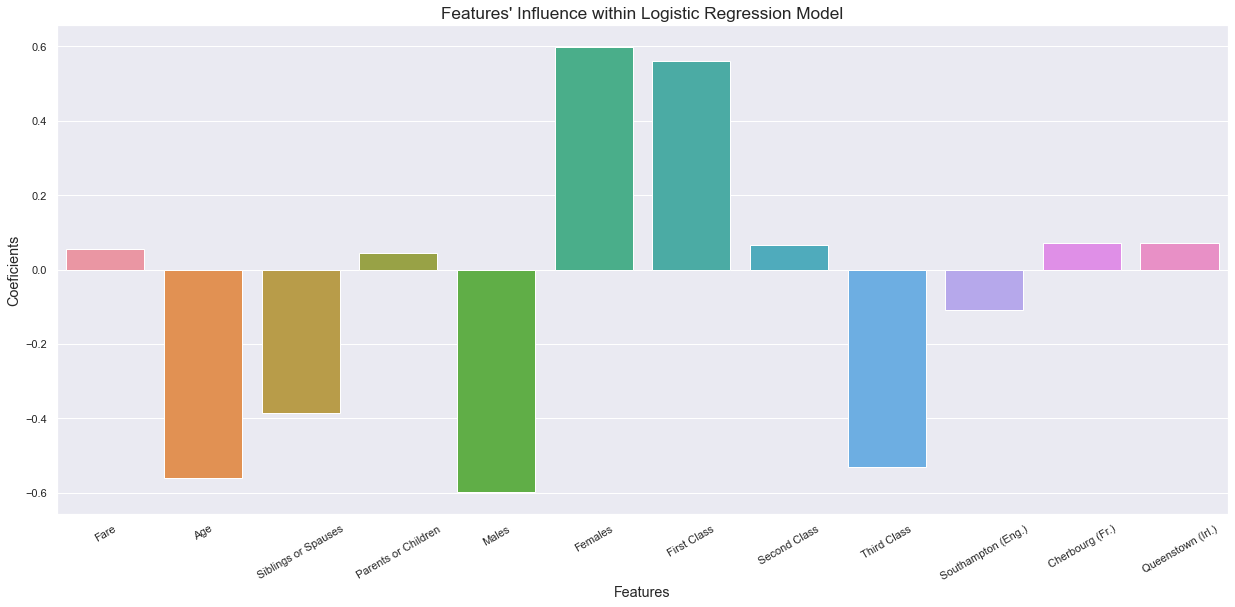

In [240]:
def visualise_barchart(feature_lst, values):
    # Prepare grid
    plt.figure(figsize = (21,9))
    
    # Draw barplot
    ax = sns.barplot(x = feature_lst, y = values)

    # Add descriptions
    plt.title('Features\' Influence within Logistic Regression Model', fontsize='x-large')
    plt.xlabel('Features', fontsize='large')
    plt.ylabel('Coeficients', fontsize='large')
    ax.set_xticklabels(['Fare', 'Age', 'Siblings or Spauses', 'Parents or Children', 'Males', 'Females', 'First Class',
       'Second Class', 'Third Class', 'Southampton (Eng.)', 'Cherbourg (Fr.)', 'Queenstown (Irl.)'], rotation=30)

    
    return plt.show()

visualise_barchart(features.columns[:], model.coef_[0] )

From the graph we can see that as well as `Sex` most impactful features were:
- `Passenger's Class`, but only the 1st and 3rd, model took Class instead of `Fare`, judging by the low impact of `Fare` itself.
- Number of `Siblings or Spauses on board` have a huge negative coefficient meaning that many of those who had such relationships were likely to die. `Parents or Children on board` did not have such a big influence, but the small they had was also negative. 
- `Age`, in spite of small correlation had a big negative influence within model, from the graph we could see that most of the survivors among men were younger people, among women survived young and middle-aged. 
- Only 2 embarkation places have at least small impact on the resulting values. If a passenger had come aboard at France they are more likely to survive if in England - other way around. Further research is required to understand what was the cause of such pattern and whether it's only quantity of passengers at play, or some other factors (and there could be more, judging by the negative coefficients of those who `Embarked in Ireland`). 


## Simulation of Extrinsic Testing

Let’s use our model to make predictions on the survival of several imagined passengers from a famous Cameron's movie "Titanic". We'll take the following characters:

- `Jack Dawson` (born 1892-1912) is the deuteragonist in Titanic and the love interest of Rose DeWitt Bukater. He was a `third-class` passenger aboard the RMS Titanic. Died.
- `Rose Dawson Calvert` (née DeWitt-Bukater, born 1895) was an American socialite and later actress. She was born in Philadelphia in 1895, but her exact birthdate is unknown. She was a `first-class` passenger aboard. Survived.
- `Caledon Nathan Hockley`, often shortened to Cal, (1882 – 1929) was an American industrialist and the heir to a Pittsburgh steel fortune.
In 1912 he was a `first-class` passenger, accompanying his 17-year-old fiancée Rose DeWitt Bukater, he survived the catastrophe.
- `Ruth DeWitt Bukater` (born in 1860s) is the mother of Rose DeWitt Bukater. She was a `first-class` passenger and survived.
- `Cora "Coraline" Cartmell` is a little girl who boarded the Titanic in 1912 with her father, Bert Cartmell and her unnamed mother, Mrs. Cartmell. She was a `third-class` passenger.
- `Fabrizio De Rossi` was a supporting character in the film, Titanic. He was Jack Dawson's best friend and trustworthy companion. He was a `third-class` passenger and died.
- `Trudy Bolt` served as the DeWitt Bukater Hockley family's maid aboard the RMS Titanic, presumably was located in a `first-class`, died in the catastrophe. 
- `Margaret Tobin Brown`, also known as "The Unsinkable Molly Brown". She was an American socialite, philanthropist and activist, `first-class` passenger, escaped catastrophe on lifeboat.
- `Wallace Henry Hartley` (2 June 1878 – 15 April 1912) was an English violinist and the bandleader on the RMS Titanic. He led the eight-member band as the ship sank on 15 April 1912. Hartley perished in the sinking, he was a `second-class` passenger.
- `Father Thomas Byles` was a Catholic priest and a `second-class` passenger on the RMS Titanic. Byles conducted church sessions for those on board. He stayed behind on the Titanic after she began sinking, though he was technically entitled to a lifeboat seat; refusing twice, died in catastrophe.

Not all available information about these passengers covers our feature list, so we'll have to make some assumptions based on available info. The arrays store 12 feature values, in the following order: `Fare`, `Age`, `SibSp` (siblings/spouses), `Parch` (children/parents), `Sex_num_0` (Male), `Sex_num_1` (Female), `Pclass_1`, `Pclass_2`, `Pclass_3`, `Embarked_num_1`(Eng.), `Embarked_num_2`(Fr.), `Embarked_num_3`(Irl.).


In [274]:
def predict_survival(model, scaler, passengers_data, features_columns, characters, survival_m, order):
    sample_passengers = pd.DataFrame(passengers_data, columns=features_columns)
    predicted = model.predict(scaler.transform(sample_passengers))
    sample_passengers['Predicted_Survival'] = predicted
    sample_passengers['Survival_in_Movie'] = survival_m
    sample_passengers['Names'] = characters
    sample_passengers = sample_passengers[order]
    return sample_passengers

In [281]:
fictional_characters = predict_survival(
    model, 
    scaler, 
    passengers_data=[
    [7.2500,20.0,0,0,1,0,0,0,1,1,0,0],
    [7.2500,23.0,0,0,1,0,0,0,1,1,0,0], 
    [452.3292,17.0,0,1,0,1,1,0,0,1,0,0],
    [437.3292,30.0,0,0,1,0,1,0,0,1,0,0],
    [452.3292,43.5,0,1,0,1,1,0,0,1,0,0],
    [8.0500,5.4,1,1,0,1,0,0,1,1,0,0],
    [120.0530,33.0,0,0,0,1,1,0,0,1,0,0],
    [315.3292,65.0,0,1,0,1,1,0,0,0,1,0],
    [124.4527,33.0,1,0,1,0,0,1,0,1,0,0],
    [92.2300,42.5,0,0,1,0,0,1,0,1,0,0]
    ], 
    features_columns=features.columns,
    characters = [  
      'Jack', 'Fabrizio', 'Rose', 'Cal',
      'Ruth', 'Cora', 'Trudy', 'Molly Brown', 
      'Violinist Bandleader', 'Father Thomas'
      ],
    survival_m = [0,0,1,1,1,0,0,1,0,0],
    order = [
      'Names', 'Survival_in_Movie', 'Predicted_Survival', 
      'Fare', 'Age', 'SibSp', 'Parch', 'Sex_num_0', 'Sex_num_1', 'Pclass_1',
      'Pclass_2', 'Pclass_3', 'Embarked_num_1', 'Embarked_num_2',
      'Embarked_num_3'
      ]
      )

fictional_characters

,Names,Survival_in_Movie,Predicted_Survival,Fare,Age,SibSp,Parch,Sex_num_0,Sex_num_1,Pclass_1,Pclass_2,Pclass_3,Embarked_num_1,Embarked_num_2,Embarked_num_3
0,Jack,0,0,7.2500,20.0,0,0,1,0,0,0,1,1,0,0
1,Fabrizio,0,0,7.2500,23.0,0,0,1,0,0,0,1,1,0,0
2,Rose,1,1,452.3292,17.0,0,1,0,1,1,0,0,1,0,0
3,Cal,1,1,437.3292,30.0,0,0,1,0,1,0,0,1,0,0
4,Ruth,1,1,452.3292,43.5,0,1,0,1,1,0,0,1,0,0
5,Cora,0,1,8.0500,5.4,1,1,0,1,0,0,1,1,0,0
6,Trudy,0,1,120.0530,33.0,0,0,0,1,1,0,0,1,0,0
7,Molly Brown,1,1,315.3292,65.0,0,1,0,1,1,0,0,0,1,0
8,Violinist Bandleader,0,0,124.4527,33.0,1,0,1,0,0,1,0,1,0,0
9,Father Thomas,0,0,92.2300,42.5,0,0,1,0,0,1,0,1,0,0


## Conclusion

If we compare results of `Survival_in_Movie` and `Predicted_Survival` we'll find that model did pretty good estimation, with a couple of  exceptions like Trudy and Cora.

These 2 could be considered as special cases for our model, because their parameters stand out compared to others. Trudy was a maid who should have been second or third-class passenger by her financial and social status, but was located in a very proximity with first-class passengers, so technically was considered also a first-class passenger. Though I made her fare  level close to one of  the second-class passengers, model predicted her survival. In the movie, as well, unfortunately, as in real life - almost all domestic servants, by the will of their owners or not, were left to the mercy of fate. As a result many of them, most likely, died, like the character of Trudy did. 

Cora's survival predicted by the model is not easy to explain. On one hand young females with low cost tickets and being third-class passengers were likely to die. But maybe she was too young to get in this category, and in spite having sibling and parents (those have negative coefficients within model) was predicted to survive. In the movie, though, this character also died, most likely to represent a sad truth of real-life implementation of the famous saying: "Women and children first".

To account for such special cases one could implement regex special rules for the model.